# Skill relative to persistence seems to last indefinitely for some variables. 

Let's make sure we understand this

In [67]:
import xarray as xr

import matplotlib.pyplot as plt

from src import utils, verify

In [6]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Let's investigate using tropics-average precip

In [62]:
def tropics_mean(ds):
    return ds.sel(lat=slice(-30, 30)).weighted(ds["area"]).mean(["lat", "lon"])

In [99]:
observation = xr.open_zarr(
    "../../data/processed/GPCP.annual.anom_1991-2020.precip_global.zarr"
)
observation = observation.where(observation.time.dt.month == 10, drop=True)

hindcast = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.anom_1991-2020.precip_global.zarr"
)

In [100]:
observation_trop = tropics_mean(observation).compute()
hindcast_trop = tropics_mean(hindcast).compute()

In [102]:
period = ["1991-01-01", "2020-12-31"]

skill = verify.calculate_metric(
    utils.keep_period(hindcast_trop, period),
    observation_trop,
    metric="msss",
    reference="persistence",
)

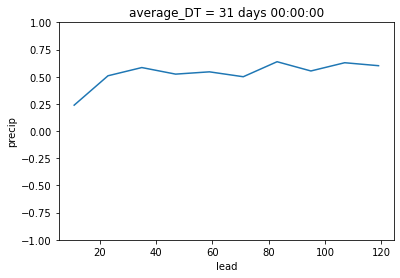

In [122]:
skill["precip"].plot()
_ = plt.ylim(-1, 1)

## Let's look at some timeseries

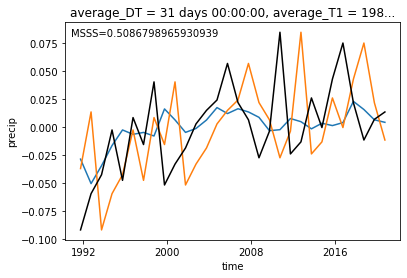

In [156]:
lead = 1

hindcast_at_lead = (
    hindcast_trop.isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=slice(period[0], period[1]))
)
persistence_forecast = observation_trop.shift(time=lead + 1).sel(
    time=hindcast_at_lead.time
)
observation_at_lead = observation_trop.sel(time=hindcast_at_lead.time)

s = verify.msss(hindcast_at_lead, observation_at_lead, persistence_forecast)[
    "precip"
].values

hindcast_at_lead["precip"].mean("member").plot()
persistence_forecast["precip"].plot()
observation_at_lead["precip"].plot(color="k")
_ = plt.text(
    0.05,
    0.96,
    f"MSSS={s}",
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes,
)

## So it looks like the hindcasts benefit from the smoothing applied by the ensemble mean. Also they remain contemporary (e.g. to a trend) whereas the persistence baseline obviously does not